In [1]:
# pip install opencv-python

In [2]:
import matplotlib
import sklearn
import numpy as np
import pandas as pd
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import pathlib
import os
import cv2
import datetime

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint,CSVLogger
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers

print("Versions of key libraries")
print("---")
print("tensorflow: ", tf.__version__)
print("numpy:      ", np.__version__)
print("matplotlib: ", matplotlib.__version__)
print("sklearn:    ", sklearn.__version__)

Versions of key libraries
---
tensorflow:  2.6.0
numpy:       1.22.3
matplotlib:  3.5.2
sklearn:     1.1.1


In [3]:
modelname   = 'compare'

IMGSIZE = 128
EPOCHS = 12
BATCH_SIXE = 16
OPT_IDX = 0

modelname = modelname+"_"+str(IMGSIZE)+"_"+str(EPOCHS)+"_"+str(BATCH_SIXE)+"_"+str(OPT_IDX)
optmzs = ['adam', optimizers.RMSprop(learning_rate=0.0001), 'rmsprop']
optmz = optmzs[OPT_IDX]

In [4]:
def createDualTwModel():
    Lin = Input(shape=(IMGSIZE,IMGSIZE,3))
    Lx = Conv2D(64,(3,3),padding='same',activation='relu')(Lin)
    Rin = Input(shape=(IMGSIZE,IMGSIZE,3))
    Rx = Conv2D(64,(3,3),padding='same',activation='relu')(Rin)
    
    shared = Conv2D(32,(3,3), padding='same', activation='relu', name='SharedLyr')
    Lx = shared(Lx)
    Rx = shared(Rx)
    
    Lx = MaxPooling2D(pool_size=(2,2))(Lx)
    Rx = MaxPooling2D(pool_size=(2,2))(Rx)

    shared2 = Conv2D(32,(3,3), padding='same', activation='relu', name='SharedLyr2')
    Lx = shared2(Lx)
    Rx = shared2(Rx)

    Lx = MaxPooling2D(pool_size=(2,2))(Lx)
    Rx = MaxPooling2D(pool_size=(2,2))(Rx)

    shared3 = Conv2D(16,(3,3), padding='same', activation='relu', name='SharedLyr3')
    Lx = shared3(Lx)
    Rx = shared3(Rx)

    Lx = MaxPooling2D(pool_size=(2,2))(Lx)
    Rx = MaxPooling2D(pool_size=(2,2))(Rx)
    
    x = concatenate([Lx,Rx],axis=-1)
    x = Flatten()(x)
    x = Dense(64,activation='relu')(x)
    x = Dense(10,activation='relu')(x)
    x = Dense(1,activation='sigmoid')(x)

    model = Model(inputs=[Lin,Rin],outputs=x)
    model.compile(loss='binary_crossentropy', 
                  optimizer=optmz, 
                  metrics=['accuracy'])
    
    return model

model       = createDualTwModel() # This is meant for training
modelGo     = createDualTwModel() # This is used for final testing

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 64) 1792        input_2[0][0]                    
______________________________________________________________________________________________

In [5]:
                                                                                # Step 1
modelname       = modelname+"_"+str(datetime.datetime.now())[:-7].replace(' ','_').replace(":",'-')
folderpath      = 'models/'
filepath        = folderpath + modelname + ".hdf5"
checkpoint      = ModelCheckpoint(filepath, 
                                  monitor='val_accuracy', 
                                  verbose=0, 
                                  save_best_only=True, 
                                  mode='max')

csv_logger      = CSVLogger(folderpath+modelname +'.csv')                       # Step 2
callbacks_list  = [checkpoint,csv_logger]                                       # Step 3

print("Path to model:", filepath)
print("Path to log:  ", folderpath+modelname+'.csv')

Path to model: models/compare_128_12_16_0_2022-09-18_22-50-58.hdf5
Path to log:   models/compare_128_12_16_0_2022-09-18_22-50-58.csv


In [6]:
plotpath  = folderpath+modelname+'_plot.png'
plot_model(model, 
           to_file=plotpath, 
           show_shapes=True, 
           show_layer_names=False,
           rankdir='TB')
print("Path to plot:", plotpath)

Path to plot: models/compare_128_12_16_0_2022-09-18_22-50-58_plot.png


In [7]:
data_dir = pathlib.Path("dataset")
fish_images_dict = {
    'arowana': list(data_dir.glob('arowana/*.jpg')),
    'betta': list(data_dir.glob('betta/*.jpg')),
    'goldfish': list(data_dir.glob('goldfish/*.jpg')),
    'luohan': list(data_dir.glob('luohan/*.jpg'))
}
labelname = ['arowana','betta','goldfish','luohan']

In [8]:
sampleFiles = ['dataset/samples/arowana.jpg', 'dataset/samples/betta.jpg', 'dataset/samples/goldfish.jpg', 'dataset/samples/luohan.jpg']
samples = []
for image in sampleFiles:
    print(str(image))
    img = cv2.imread(str(image))
    resized_img = cv2.resize(img,(IMGSIZE,IMGSIZE))
    samples.append(resized_img)

dataset/samples/arowana.jpg
dataset/samples/betta.jpg
dataset/samples/goldfish.jpg
dataset/samples/luohan.jpg


In [9]:
X, y, z = [], [], []

for fish_name, images in fish_images_dict.items():
    for image in images:
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img,(IMGSIZE,IMGSIZE))
        for (i, sample) in enumerate(samples):
            X.append(resized_img)
            z.append(sample)
            res = 1 if labelname.index(fish_name)==i else 0
            y.append(res)

In [10]:
X = np.array(X)
y = np.array(y)
z = np.array(z)
# y = to_categorical(oy)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test, z_train, z_test = train_test_split(X, y, z, random_state=42)
X_train  = X_train / 255
X_test   = X_test / 255
z_train  = z_train / 255
z_test   = z_test / 255

In [11]:
history = model.fit([X_train,z_train],                            # Training data
          y_train,                            # Training label
          validation_data=([X_test,z_test], y_test),   # Validation data and label
          epochs=EPOCHS,                       # The amount of epochs to be trained
          batch_size=BATCH_SIXE,                   
          shuffle=True,                     # To shuffle the training data
          callbacks=callbacks_list)         # Callbacks to execute the checkpoints

Epoch 1/12
577/577 [==============================] - 20s 29ms/step - loss: 0.5195 - accuracy: 0.7498 - val_loss: 0.5035 - val_accuracy: 0.7494
Epoch 2/12
577/577 [==============================] - 15s 26ms/step - loss: 0.5126 - accuracy: 0.7502 - val_loss: 0.5064 - val_accuracy: 0.7494
Epoch 3/12
577/577 [==============================] - 15s 27ms/step - loss: 0.5045 - accuracy: 0.7502 - val_loss: 0.4880 - val_accuracy: 0.7494
Epoch 4/12
577/577 [==============================] - 15s 27ms/step - loss: 0.4624 - accuracy: 0.7617 - val_loss: 0.4544 - val_accuracy: 0.7859
Epoch 5/12
577/577 [==============================] - 16s 27ms/step - loss: 0.3690 - accuracy: 0.8330 - val_loss: 0.3146 - val_accuracy: 0.8643
Epoch 6/12
577/577 [==============================] - 16s 27ms/step - loss: 0.2705 - accuracy: 0.8834 - val_loss: 0.3269 - val_accuracy: 0.8588
Epoch 7/12
577/577 [==============================] - 16s 27ms/step - loss: 0.2084 - accuracy: 0.9139 - val_loss: 0.3038 - val_accuracy:

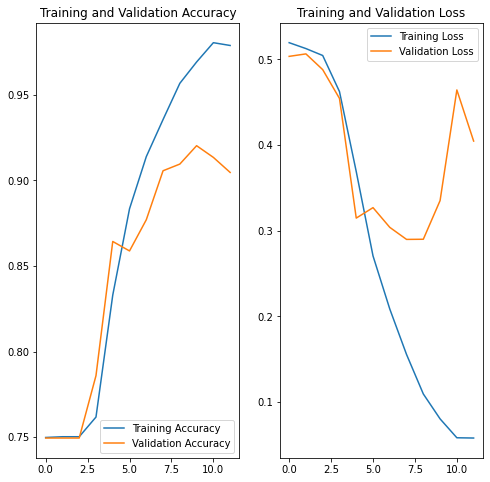

In [12]:
# Plot the accuracy and error on training and test sets

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig(folderpath+modelname+'_accuracy_plot.png')
plt.show()

In [13]:
                                                                                # Step 1
modelGo.load_weights(filepath)
modelGo.compile(loss='binary_crossentropy', 
                optimizer=optmz, 
                metrics=['accuracy'])

predicts    = modelGo.predict([X_test,z_test])                                            # Step 2
print("Prediction completes.")

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

In [ ]:
                                                                                # Step 1
                                                                                # Step 2
predout     = np.argmax(predicts,axis=1)
testout     = np.argmax(y_test,axis=1)

testScores  = metrics.accuracy_score(testout,predout)                           # Step 3

                                                                                # Step 4
print("Best accuracy (on testing dataset): %.2f%%" % (testScores*100))
print(metrics.classification_report(testout,
                                    predout,
                                    target_names=["false","true"],
                                    digits=4))

report = metrics.classification_report(testout,
                                    predout,
                                    target_names=["false","true"],
                                    digits=4,
                                      output_dict=True)

df = pd.DataFrame(report).transpose()
df.to_csv(folderpath+modelname+'_report.csv')